In [2]:
from google.colab import files
import seaborn as sns
import io
import pandas as pd
import numpy as np
import statsmodels.api as sm
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from scipy import signal

# 1º Practical assignment

In [3]:
uploaded = files.upload()

Saving MOB_Dataset1_A6_M12.csv to MOB_Dataset1_A6_M12.csv
Saving MOB_Dataset1_A6_M11.csv to MOB_Dataset1_A6_M11.csv
Saving MOB_Dataset1_A5_M9.csv to MOB_Dataset1_A5_M9.csv
Saving MOB_Dataset1_A5_M10.csv to MOB_Dataset1_A5_M10.csv
Saving MOB_Dataset1_A4_M8.csv to MOB_Dataset1_A4_M8.csv
Saving MOB_Dataset1_A4_M7.csv to MOB_Dataset1_A4_M7.csv
Saving MOB_Dataset1_A3_M6.csv to MOB_Dataset1_A3_M6.csv
Saving MOB_Dataset1_A3_M5.csv to MOB_Dataset1_A3_M5.csv
Saving MOB_Dataset1_A2_M4.csv to MOB_Dataset1_A2_M4.csv
Saving MOB_Dataset1_A2_M3.csv to MOB_Dataset1_A2_M3.csv
Saving MOB_Dataset1_A1_M2.csv to MOB_Dataset1_A1_M2.csv
Saving MOB_Dataset1_A1_M1.csv to MOB_Dataset1_A1_M1.csv


In [4]:
A1M1_df = pd.read_csv('MOB_Dataset1_A1_M1.csv', names=['y','u'])
A1M2_df = pd.read_csv('MOB_Dataset1_A1_M2.csv', names=['y','u'])
A2M1_df = pd.read_csv('MOB_Dataset1_A2_M3.csv', names=['y','u'])
A2M2_df = pd.read_csv('MOB_Dataset1_A2_M4.csv', names=['y','u'])
A3M1_df = pd.read_csv('MOB_Dataset1_A3_M5.csv', names=['y','u'])
A3M2_df = pd.read_csv('MOB_Dataset1_A3_M6.csv', names=['y','u'])
A4M1_df = pd.read_csv('MOB_Dataset1_A4_M7.csv', names=['y','u'])
A4M2_df = pd.read_csv('MOB_Dataset1_A4_M8.csv', names=['y','u'])
A5M1_df = pd.read_csv('MOB_Dataset1_A5_M9.csv', names=['y','u'])
A5M2_df = pd.read_csv('MOB_Dataset1_A5_M10.csv', names=['y','u'])
A6M1_df = pd.read_csv('MOB_Dataset1_A6_M11.csv', names=['y','u'])
A6M2_df = pd.read_csv('MOB_Dataset1_A6_M12.csv', names=['y','u'])

athlete_list = [A1M1_df, A1M2_df, A2M1_df, A2M2_df, A3M1_df, A3M2_df, A4M1_df, A4M2_df, A5M1_df, A5M2_df, A6M1_df, A6M2_df]
code_name = ['A1M1', 'A1M2', 'A2M1', 'A2M2', 'A3M1', 'A3M2', 'A4M1', 'A4M2', 'A5M1', 'A5M2', 'A6M1', 'A6M2']

Athlete:(7743, 2)
Athlete:(4460, 2)
Athlete:(7743, 2)
Athlete:(4460, 2)
Athlete:(5895, 2)
Athlete:(4626, 2)
Athlete:(6823, 2)
Athlete:(4906, 2)
Athlete:(6823, 2)
Athlete:(4906, 2)
Athlete:(6823, 2)
Athlete:(4906, 2)


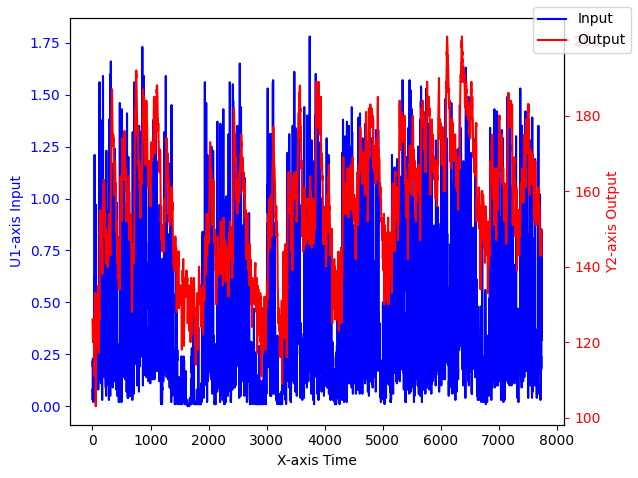

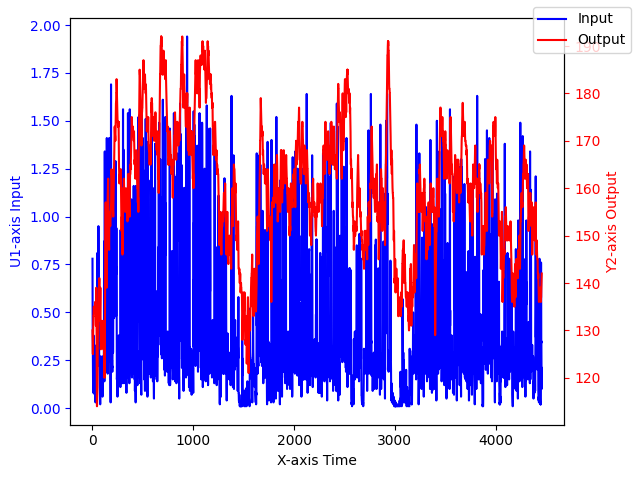

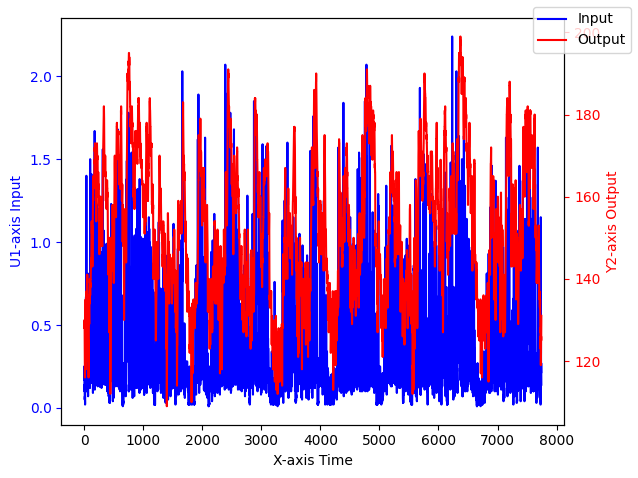

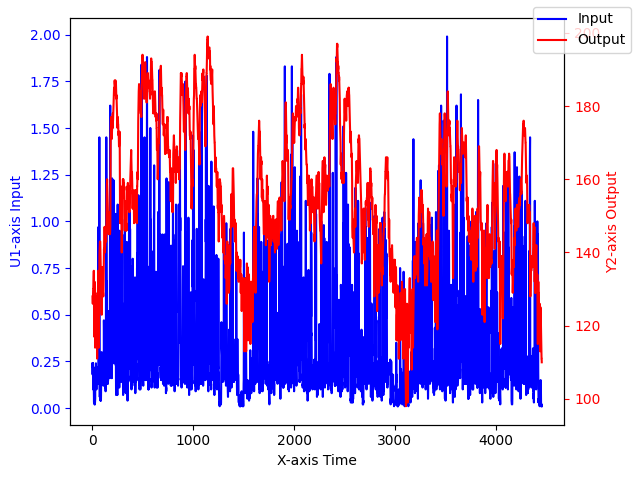

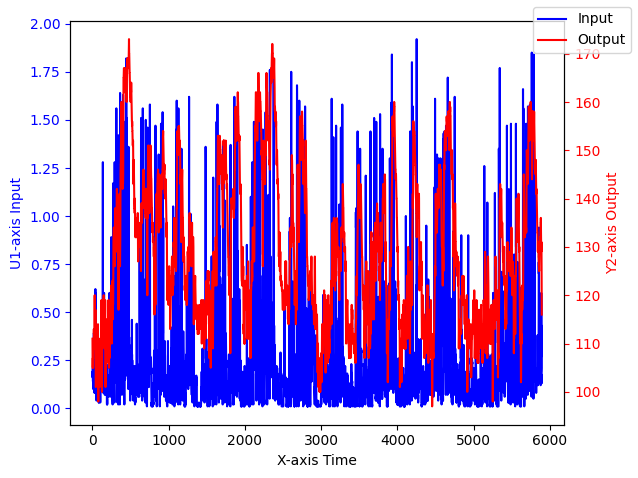

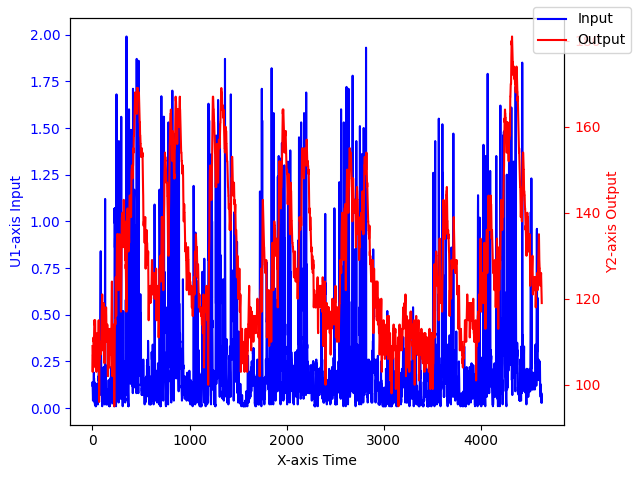

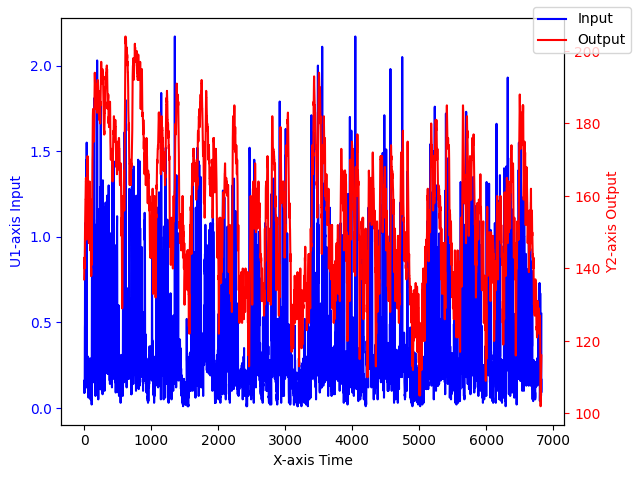

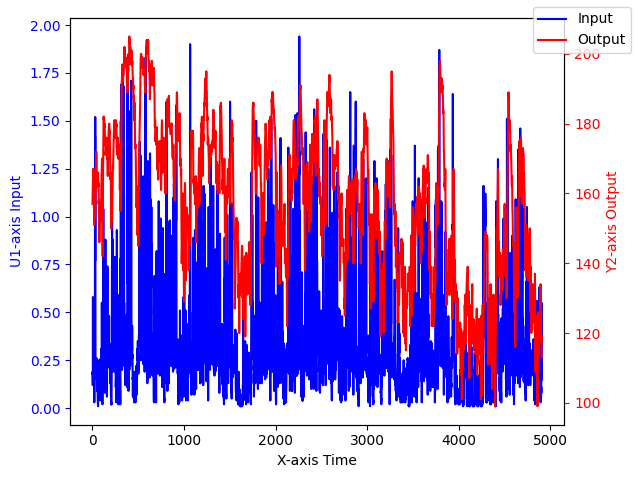

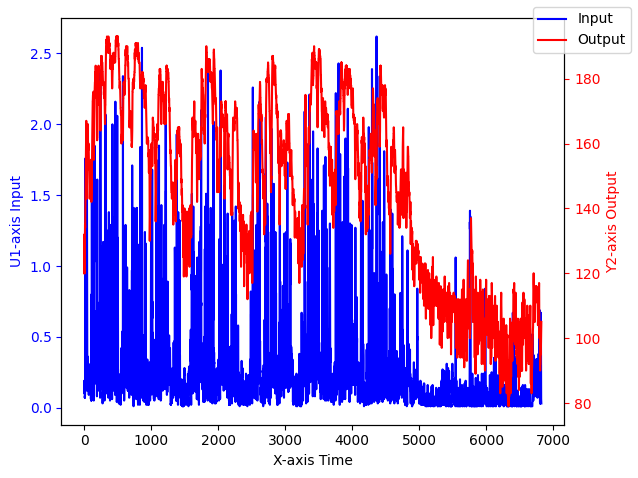

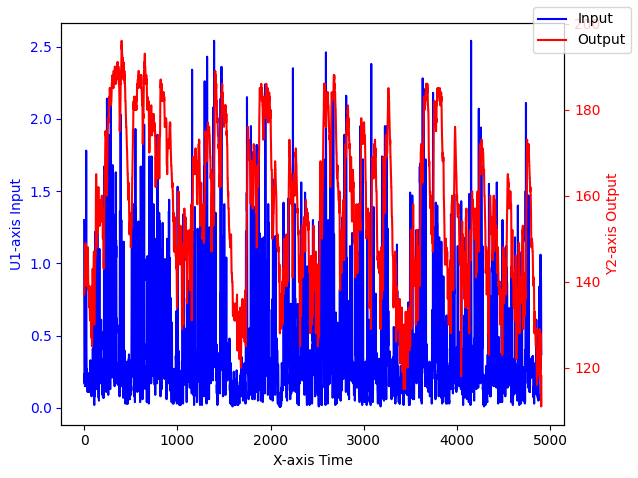

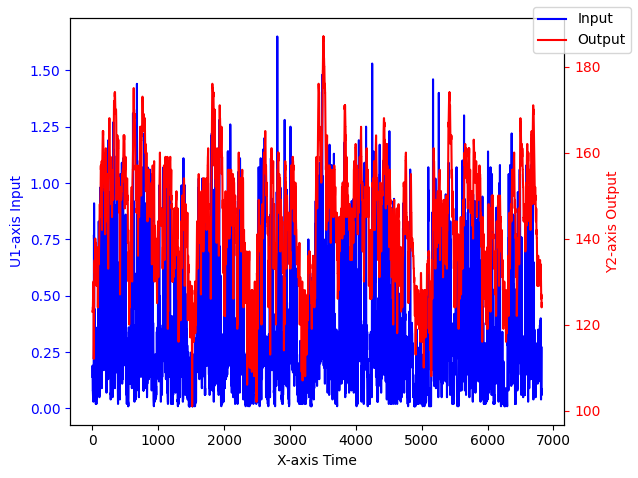

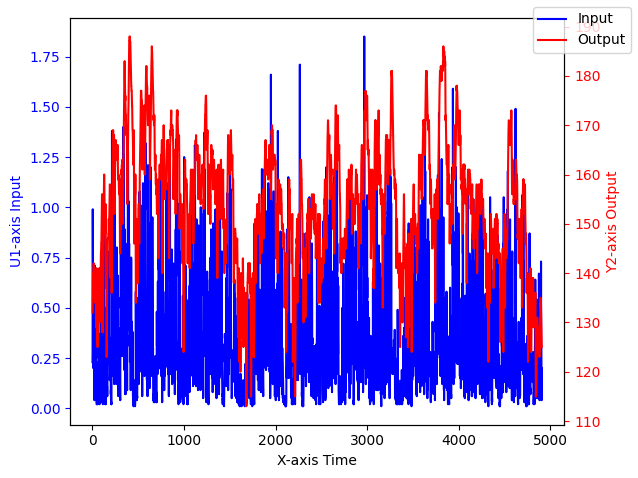

In [8]:
#1ºData Preparation
#Pre-processing && Ploting

for athlete in athlete_list:
  #Start all values at Zero
  #athlete['u'] = athlete['u'] - athlete['u'][0]
  #athlete['y'] = athlete['y'] - athlete['y'][0]
  print(f"Athlete:{athlete.shape}")

  #Ploting using two axis with different scales
  fig, ax1 = plt.subplots()
  ax1.plot(athlete['u'], color='blue', label='Input')
  ax1.set_xlabel('X-axis Time')
  ax1.set_ylabel('U1-axis Input', color='blue')
  ax1.tick_params('y', colors='blue')
  ax2 = ax1.twinx()
  ax2.plot(athlete['y'], color='red', label='Output')
  ax2.set_ylabel('Y2-axis Output', color='red')
  ax2.tick_params('y', colors='red')
  fig.legend(loc="upper right")
  fig.tight_layout()


## 2º System Identification

In [9]:
#2ºSystem Identification
def calcmodel(data, na, nb, d):
    # Load the associated data using dataloader(data, na, nb, d)
    X_loader, y_loader = dataloader(data, na, nb, d)


    # Estimate the a and b parameters vector [a0...an, b0...bm].T by the formula inv(X.T dot X) dot X.T dot y
    params = np.linalg.inv(X_loader.T @ X_loader) @ X_loader.T @ y_loader
    #params = np.linalg.solve(X_loader.T, X_loader) @ X_loader.T @ y_loader
    params = params.values


    parameters_a = params[:na]
    parameters_b = params[na:]


    # Optional: Calculate the predicted values of Y via Matrix-Vector multiplication (this is for prediction, not simulation)
    Y_pred = np.dot(X_loader, params)


    #Calculate a simulation using the predicted parameters use the following structure:
    ysim = np.zeros((len(X_loader)+1,1))  # the plus one is because the first value is initialized and not simulated

    ysim[0] = y_loader.values[0]    # initialize the first value
    max_lag = max(na, nb + d)  # Maximum lag across both endogenous and exogenous variables

    for k in range(max_lag, len(X_loader)):
        # Add the contribution from autoregressive terms (endogenous variables)
        for i_a in range(1, na + 1):
            #ysim[k] += parameters_a[i_a - 1] * ysim[k - i_a]
            ysim[k] += parameters_a[i_a - 1] * X_loader.iloc[k, i_a]

        # Add the contribution from exogenous input ter\ms (with delay d)
        for j_b in range(1, nb + 1):
            #ysim[k] += estimation[i_a - 1] * ysim[k - i_a - X_loader['u-{}'.format(d)]]                    #to get the column at delay u-d use this syntax X_loader['u-{}'.format(d)]
            ysim[k] += parameters_b[j_b-1] * X_loader['u-{}'.format(d)].iloc[k-j_b]


    # Calculate r-squared
    y_loader = y_loader.values.reshape(-1,1)
    SS_res = np.sum((y_loader - ysim[1:]) ** 2)  # Residual sum of squares
    SS_tot = np.sum((y_loader - np.mean(y_loader)) ** 2)  # Total sum of squares
    rsq = 1 - (SS_res / SS_tot)
    #print("ss_red:",SS_res,"ss_tot",SS_tot,"RSQ:",rsq)


    # Calculate AIC
    n = len(y_loader)  # Number of observations
    k = len(params)  # Number of parameters (including intercept)
    aic = 2 * k + n * np.log(SS_res / n)



    return Y_pred, ysim, params, rsq, aic






In [19]:
pds

,Athlete,na,nb,d,Params,RSQ,AIC
0,A1M1,1,1,1,"[1.6380094059872423, 0.9964293972536942]",-33.986299,71433.338170
1,A1M1,1,1,2,"[1.5175464296500092, 0.9966806913864246]",-22.077422,68201.047732
2,A1M1,1,1,3,"[1.1414964864328452, 0.9974899964437086]",-0.791477,48410.133432
3,A1M1,1,2,1,"[1.1861458013243096, 0.569266426128757, 0.9961...",-83.364288,78236.328041
4,A1M1,1,2,2,"[1.666608165660107, -0.188278502610296, 0.9967...",-83.496738,78235.703071
...,...,...,...,...,...,...,...
319,A6M2,3,2,2,"[0.9560693211521427, -0.23768917577346102, 1.6...",-24.846201,41016.005826
320,A6M2,3,2,3,"[0.2640504657645768, 0.2901918450212137, 1.680...",-133.765152,49100.862387
321,A6M2,3,3,1,"[1.3624372168046421, -0.11448840364708456, -0....",-207.109464,51243.090551
322,A6M2,3,3,2,"[0.9638638719331218, -0.47926211196878515, 0.3...",-66.336972,45702.429946


In [17]:
# Initialize an empty DataFrame to store results
pds = pd.DataFrame(columns=["Athlete", "na", "nb", "d", "Params", "RSQ", "AIC"])

# Parameter ranges
na_max = nb_max = xdelay_max = 3
# Iterate over each athlete
for i in range(len(athlete_list)):
    print(f"Athlete: {code_name[i]}")
    athlete = athlete_list[i]
    # Iterate over possible values of na, nb, and d
    for na in range(1,na_max+1):
      for nb in range(1,nb_max+1):
        for d in range(1,xdelay_max+1):
              # Calculate model with specified parameters
              Y_pred, ysim, params, rsq, aic = calcmodel(athlete, na=na, nb=nb, d=d)


              # Add the result as a new row to the DataFrame
              pds = pd.concat([pds, pd.DataFrame({
                  "Athlete": f"{code_name[i]}",
                  "na": [na],
                  "nb": [nb],
                  "d": [d],
                  "Params": [params],
                  "RSQ": [rsq],
                  "AIC": [aic]
              })], ignore_index=True)

# Display final DataFrame with all results
#print(pds)


#Logs
'''
Run   Time
1     24:23       #First version(5)
2     24:23          #Add to dataframe(5)
3     25:xx        #No Idea(5)
4     5:xx         #Normal(3)
'''

Athlete: A1M1


<ipython-input-17-fa50d3912500>:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pds = pd.concat([pds, pd.DataFrame({


Athlete: A1M2
Athlete: A2M1
Athlete: A2M2
Athlete: A3M1
Athlete: A3M2
Athlete: A4M1
Athlete: A4M2
Athlete: A5M1
Athlete: A5M2
Athlete: A6M1
Athlete: A6M2


'\nRun   Time\n1     24:23       #First version(5)\n2     24:23          #Add to dataframe(5)\n3     25:xx        #No Idea(5)\n4     5:xx         #Normal(3)\n5     0:56         #Normal(2)\n6     0:23           #T-GPU(3)\n'

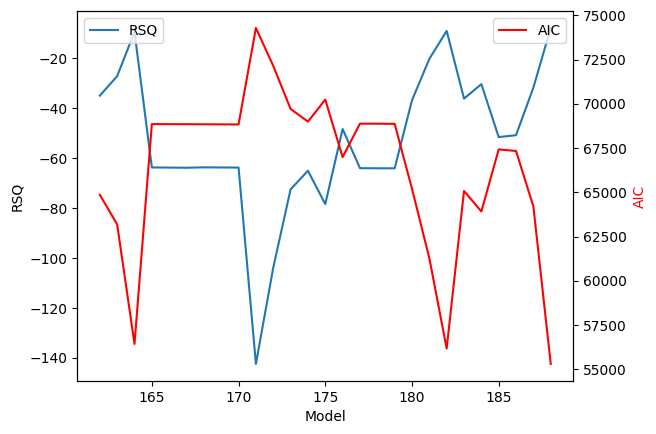

<Figure size 1000x600 with 0 Axes>

,na,nb,d,RSQ,AIC
162,1,1,1,-35.031329,64859.202209
163,1,1,2,-27.212477,63181.720910
164,1,1,3,-9.494269,56429.428797
165,1,2,1,-63.783228,68853.066937
166,1,2,2,-63.831687,68848.590613
167,1,2,3,-63.899947,68846.258210
168,1,3,1,-63.742059,68841.156993
169,1,3,2,-63.790222,68836.721506
170,1,3,3,-63.830146,68831.270808
171,2,1,1,-142.468724,74285.970656


In [22]:

A1M1 = pds[pds['Athlete'] == "A4M1"]
percentile_75_1 = A1M1['AIC'].quantile(0.9)
percentile_75_2 = np.percentile(A1M1['AIC'],90)
#print(percentile_75_1, percentile_75_2)
#A1M1 = A1M1[A1M1['RSQ'] >= percentile_75]
#print(A1M1)

percentile_95 = A1M1['RSQ'].quantile(0.75)
fig, ax1 = plt.subplots()
plt.figure(figsize=(10, 6))
ax1.plot(A1M1["RSQ"])
ax1.set_xlabel('Model')
ax1.set_ylabel('RSQ')
ax2 = ax1.twinx()
ax2.plot(A1M1["AIC"], color='red')
ax2.set_ylabel('AIC', color='red')
ax1.legend(['RSQ'], loc='upper left')
ax2.legend(['AIC'], loc='upper right')
plt.show()
#pds
#Logs
'''
Total: 1500 Models
'''
A1M1[['na', 'nb','d','RSQ','AIC']][0:]

In [ ]:
#3 Biological interpretation

# 2º Practical assignment

In [ ]:
uploaded = files.upload()

In [ ]:
# Mutant 334

M334_C1_In_df = pd.read_csv('Mutation334_C1_In.csv', names=['u'])
M334_C2_In_df = pd.read_csv('Mutation334_C2_In.csv', names=['u'])
M334_C3_In_df = pd.read_csv('Mutation334_C3_In.csv', names=['u'])
M334_C4_In_df = pd.read_csv('Mutation334_C4_In.csv', names=['u'])
M334_C5_In_df = pd.read_csv('Mutation334_C5_In.csv', names=['u'])
M334_C6_In_df = pd.read_csv('Mutation334_C6_In.csv', names=['u'])

M334_C1_Out_df = pd.read_csv('Mutation334_C1_Out.csv', names=['y'])
M334_C2_Out_df = pd.read_csv('Mutation334_C2_Out.csv', names=['y'])
M334_C3_Out_df = pd.read_csv('Mutation334_C3_Out.csv', names=['y'])
M334_C4_Out_df = pd.read_csv('Mutation334_C4_Out.csv', names=['y'])
M334_C5_Out_df = pd.read_csv('Mutation334_C5_Out.csv', names=['y'])
M334_C6_Out_df = pd.read_csv('Mutation334_C6_Out.csv', names=['y'])

Mutant_334_list = [M334_C1_In_df,
M334_C2_In_df,
M334_C3_In_df,
M334_C4_In_df,
M334_C5_In_df,
M334_C6_In_df,
M334_C1_Out_df,
M334_C2_Out_df,
M334_C3_Out_df,
M334_C4_Out_df,
M334_C5_Out_df,
M334_C6_Out_df]

# Mutant 343

M343_C1_In_df = pd.read_csv('Mutation343_C1_In.csv', names=['u'])
M343_C2_In_df = pd.read_csv('Mutation343_C2_In.csv', names=['u'])
M343_C3_In_df = pd.read_csv('Mutation343_C3_In.csv', names=['u'])
M343_C4_In_df = pd.read_csv('Mutation343_C4_In.csv', names=['u'])
M343_C5_In_df = pd.read_csv('Mutation343_C5_In.csv', names=['u'])
M343_C6_In_df = pd.read_csv('Mutation343_C6_In.csv', names=['u'])

M343_C1_Out_df = pd.read_csv('Mutation343_C1_Out.csv', names=['y'])
M343_C2_Out_df = pd.read_csv('Mutation343_C2_Out.csv', names=['y'])
M343_C3_Out_df = pd.read_csv('Mutation343_C3_Out.csv', names=['y'])
M343_C4_Out_df = pd.read_csv('Mutation343_C4_Out.csv', names=['y'])
M343_C5_Out_df = pd.read_csv('Mutation343_C5_Out.csv', names=['y'])
M343_C6_Out_df = pd.read_csv('Mutation343_C6_Out.csv', names=['y'])

Mutant_343_list = [M343_C1_In_df,
M343_C2_In_df,
M343_C3_In_df,
M343_C4_In_df,
M343_C5_In_df,
M343_C6_In_df,
M343_C1_Out_df,
M343_C2_Out_df,
M343_C3_Out_df,
M343_C4_Out_df,
M343_C5_Out_df,
M343_C6_Out_df]

# WildType

WildType_C1_In_df = pd.read_csv('WildType_C1_In.csv', names=['u'])
WildType_C2_In_df = pd.read_csv('WildType_C2_In.csv', names=['u'])
WildType_C3_In_df = pd.read_csv('WildType_C3_In.csv', names=['u'])
WildType_C4_In_df = pd.read_csv('WildType_C4_In.csv', names=['u'])
WildType_C5_In_df = pd.read_csv('WildType_C5_In.csv', names=['u'])
WildType_C6_In_df = pd.read_csv('WildType_C6_In.csv', names=['u'])

WildType_C1_Out_df = pd.read_csv('WildType_C1_Out.csv', names=['y'])
WildType_C2_Out_df = pd.read_csv('WildType_C2_Out.csv', names=['y'])
WildType_C3_Out_df = pd.read_csv('WildType_C3_Out.csv', names=['y'])
WildType_C4_Out_df = pd.read_csv('WildType_C4_Out.csv', names=['y'])
WildType_C5_Out_df = pd.read_csv('WildType_C5_Out.csv', names=['y'])
WildType_C6_Out_df = pd.read_csv('WildType_C6_Out.csv', names=['y'])

WildType_list = [WildType_C1_In_df,
WildType_C2_In_df,
WildType_C3_In_df,
WildType_C4_In_df,
WildType_C5_In_df,
WildType_C6_In_df,
WildType_C1_Out_df,
WildType_C2_Out_df,
WildType_C3_Out_df,
WildType_C4_Out_df,
WildType_C5_Out_df,
WildType_C6_Out_df]

# Unknown

Unknown_C1_In_df = pd.read_csv('Unknown_C1_In.csv', names=['u'])
Unknown_C2_In_df = pd.read_csv('Unknown_C2_In.csv', names=['u'])

Unknown_C1_Out_df = pd.read_csv('Unknown_C1_Out.csv', names=['y'])
Unknown_C2_Out_df = pd.read_csv('Unknown_C2_Out.csv', names=['y'])

UnknownType_list = [Unknown_C1_In_df,
Unknown_C2_In_df,
Unknown_C1_Out_df,
Unknown_C2_Out_df]


In [12]:
def dataloader(data, na, nb, d):

    # Initialize empty arrays for lagged features
    u = data['u']
    X = pd.DataFrame()
    y = data['y']


    # Create lagged features for input ('b' parameters)
    for i in range(0,nb):
        X['u-{}'.format(i + d)] = u.shift(i + d)
    # Create lagged features for output ('a' parameters)
    for i in range(1,na+1):
        X['y-{}'.format(i)] = y.shift(i)


    X = X.iloc[max(na,nb+d):]
    # Set the target values
    y = y[max(na,nb+d):]

    X.reset_index(drop=True, inplace=True)
    y.reset_index(drop=True, inplace=True)
    return X, y